In [1]:
%%html
<script>
(function() {
  // Create the toggle button
  const rtlButton = document.createElement("button");
  rtlButton.textContent = "Toggle LTR";
  rtlButton.id = "top-rtl-toggle";
  rtlButton.style.marginLeft = "8px";
  rtlButton.style.padding = "4px 10px";
  rtlButton.style.fontSize = "14px";
  rtlButton.style.cursor = "pointer";

  // State
  var rtlActive = false;

  // Styling function
  var applyStyleToEditor = (editor) => {
    if (!editor) return;
    var direction = getComputedStyle(editor).getPropertyValue('direction')=='rtl' ? 'ltr' : 'rtl';
    var text_align = getComputedStyle(editor).getPropertyValue('text-align')=='right' ? 'left' : 'right';
    editor.style.setProperty('direction', direction, 'important');
    editor.style.setProperty('text-align', text_align, 'important');
  };

  // Toggle logic
  rtlButton.onclick = () => {
    rtlActive = !rtlActive;
    rtlButton.textContent = rtlActive ? "Toggle LTR" : "Toggle RTL";
    document.querySelectorAll('.jp-MarkdownCell .jp-InputArea-editor').forEach(applyStyleToEditor);
    document.querySelectorAll('.jp-RenderedHTMLCommon code, .jp-RenderedHTMLCommon code span').forEach(applyStyleToEditor);
    document.querySelectorAll('jp-RenderedHTMLCommon, .jp-RenderedHTMLCommon *').forEach(applyStyleToEditor);
  };

  // Watch for focus into editing Markdown cells
  // document.addEventListener('focusin', (event) => {
  //   const editor = event.target.closest('.jp-MarkdownCell .jp-InputArea-editor');
  //    if (editor) applyStyleToEditor(editor);
  // });

  // Insert into top toolbar if not already present
  var insertIntoToolbar = () => {
    const toolbar = document.querySelector('.jp-NotebookPanel-toolbar');
    if (toolbar && !document.getElementById("top-rtl-toggle")) {
      toolbar.appendChild(rtlButton);
    } else {
      // Try again in a moment if toolbar isn't ready yet
      setTimeout(insertIntoToolbar, 300);
    }
  };

  insertIntoToolbar();
})();
</script>

In [2]:
%%html
<!-- <style>
  table {display: inline-block}
</style> -->

## תרגיל: דוח תפעול יומי למערך גלאים

בתרגיל הזה נתרגל עבודה עם **Pandas** דרך סימולציה של מצב אמיתי מעולמות הפיזיקה הניסויית:  
מערך גלאים (למשל קרינה/קרניים קוסמיות) שמייצר **לוג אירועים** לאורך זמן, ובמקביל מערכת ניטור סביבתי שמודדת **טמפרטורה** מכמה פרובים.

המטרה שלנו היא לקחת נתונים “גולמיים” (Raw Logs) — שכוללים לפעמים **טיימסטמפים לא תקינים**, **ערכים חסרים**, וסדר לא מסודר — ולהפיק מהם **דוח יומי** נקי ושמיש.

במהלך התרגיל תתרגלו:

- **ניקוי נתונים (Data Cleaning)**  
  המרת עמודת זמן למבנה datetime עם `pd.to_datetime(..., errors="coerce")`, סילוק שורות בעייתיות, וטיפול בערכים חסרים.

- **עבודה עם תאריכים וזמן (Date/Time)**  
  חילוץ תאריך יומי מתוך timestamp (לצורך סיכום לפי ימים).

- **Pivot Tables**  
  יצירת טבלת דוח רחבה של *טמפרטורה ממוצעת לפי יום ולפי פרוב* בעזרת `pivot_table`.

- **GroupBy + size + unstack**  
  ספירת מספר אירועים לפי יום ולפי גלאי, והפיכת התוצאה לטבלה רחבה שמתאימה לדוח.

- **Merge / Join (מתקדם)**  
  חיבור לוג האירועים לטבלת מטא-דאטה של גלאים (קליברציה), כדי להמיר מדידה גולמית לערך פיזיקלי “מחושב”.

- **טרנספורמציות ועמודות נגזרות (Vectorized transforms)**  
  חישוב אנרגיה מכוילת לכל אירוע בצורה וקטורית (ללא לולאות).

- **שינויי מבנה (Reshaping)**  
  מעבר בין פורמט רחב לפורמט ארוך (`melt`) לצורך גרפים/ניתוחים.

- **ויזואליזציה מהירה**  
  גרפים בסיסיים של ספירות אירועים וטמפרטורות לאורך זמן.

התרגיל מדמה Workflow נפוץ במעבדה:
1. קבלת לוגים ממכשור מדידה (אירועים + סביבה)
2. ניקוי ותיקון נתונים
3. סיכום יומי לפי חיישנים/גלאים
4. שילוב נתוני קליברציה/מטא-דאטה
5. הפקת דוח תפעולי שמאפשר לזהות תקלות, חריגות ועקביות לאורך זמן

בסוף התרגיל יהיו לכם כמה “טבלאות דוח” מרכזיות + גרפים קצרים — בדיוק כמו בדוח ניטור יומי של מערכת מדידה אמיתית.


Raw shapes:
  detectors: (6, 4)
  events: (3500, 3)
  temps: (1400, 3)

After cleaning:
  events_clean: (3462, 4)
  temps_clean: (1378, 4)

Daily mean temperature (date x probe):
probe              T1         T2         T3
date                                       
2025-12-20  24.194321  24.023935  24.298412
2025-12-21  23.981442  24.118992  23.358882
2025-12-22  24.141287  24.032457  23.947131
2025-12-23  23.846118  23.809852  23.768130
2025-12-24  24.044219  23.900574  23.935371

Daily event counts (date x detector):
detector    D1  D2  D3  D4  D5  D6
date                              
2025-12-20  87  78  77  85  72  88
2025-12-21  85  99  67  87  94  70
2025-12-22  75  87  86  78  94  74
2025-12-23  91  86  85  91  88  73
2025-12-24  86  83  78  55  64  74

Events with calibration columns:
            timestamp        date detector module         adc      gain  \
0 2025-12-20 00:45:21  2025-12-20       D1     M1  246.435219  1.264374   
1 2025-12-21 22:27:36  2025-12-21       D1   

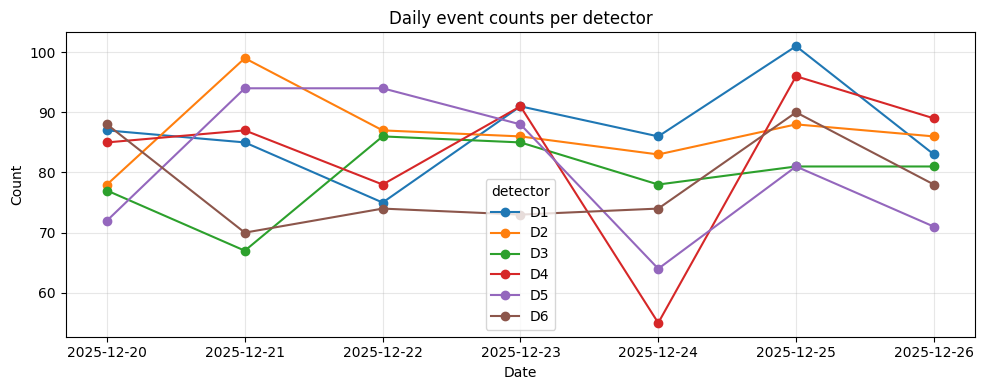

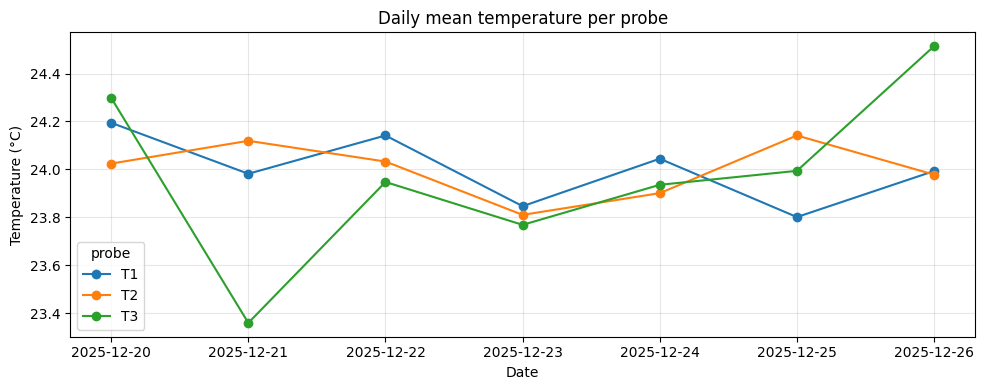

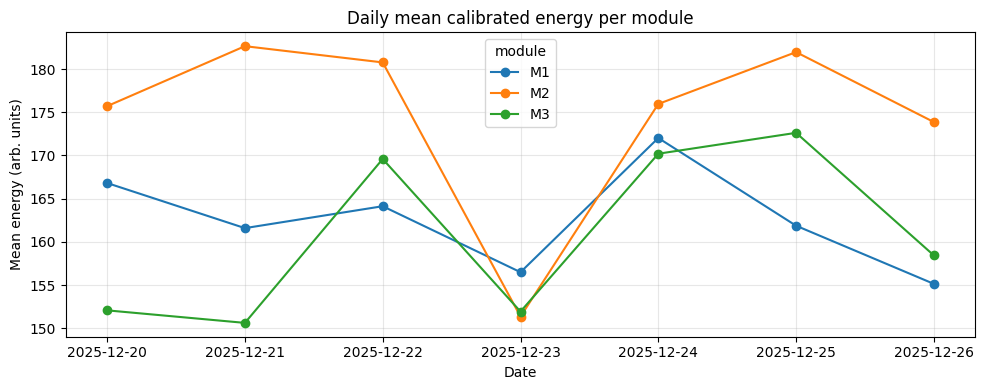


Report keys: ['daily_mean_temp', 'daily_counts', 'module_daily_summary_long', 'module_mean_energy_wide', 'counts_long', 'temps_long']


In [3]:
# Physics-inspired Pandas notebook (FULL SOLUTION CODE)
# Problem 1: "Detector Array Daily Operations Report"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) Generate synthetic-but-realistic data (raw, slightly messy)
# -----------------------------
rng = np.random.default_rng(42)

# Detector metadata / calibration
detectors = pd.DataFrame({
    "detector": [f"D{i}" for i in range(1, 7)],
    "module":   ["M1", "M1", "M2", "M2", "M3", "M3"],
    "gain":     rng.uniform(0.8, 1.4, size=6),
    "offset":   rng.uniform(-5.0, 5.0, size=6),
})

# Create a time range spanning multiple days, but events are irregular
start = pd.Timestamp("2025-12-20 00:00:00")
end   = pd.Timestamp("2025-12-26 23:59:59")
total_seconds = int((end - start).total_seconds())

n_events = 3500
event_times = start + pd.to_timedelta(rng.integers(0, total_seconds, size=n_events), unit="s")
event_times = pd.Series(event_times).sample(frac=1, random_state=0).reset_index(drop=True)  # shuffled

events = pd.DataFrame({
    "timestamp": event_times.astype(str),  # stored as strings in raw logs
    "detector": rng.choice(detectors["detector"], size=n_events, replace=True),
    "adc": rng.gamma(shape=4.0, scale=35.0, size=n_events) + rng.normal(0, 3, size=n_events),
})

# Add some deliberately invalid timestamps and a couple junk rows
bad_idx = rng.choice(events.index, size=25, replace=False)
events.loc[bad_idx, "timestamp"] = rng.choice(
    ["not_a_time", "2025-13-99 99:99:99", "", "2025/12/25 25:61:00"],
    size=len(bad_idx),
)
# Also introduce some missing adc values
events.loc[rng.choice(events.index, size=15, replace=False), "adc"] = np.nan

# Temperature probe logs (more regular, but still messy)
probes = ["T1", "T2", "T3"]
n_temps = 1400
temp_times = start + pd.to_timedelta(rng.integers(0, total_seconds, size=n_temps), unit="s")

temps = pd.DataFrame({
    "timestamp": pd.Series(temp_times).astype(str),
    "probe": rng.choice(probes, size=n_temps, replace=True),
    "temp_C": rng.normal(loc=24.0, scale=1.7, size=n_temps),
})

# Add a few invalid timestamps and missing temps
bad_idx_t = rng.choice(temps.index, size=12, replace=False)
temps.loc[bad_idx_t, "timestamp"] = rng.choice(["bad", "2025-12-XX 12:00:00", ""], size=len(bad_idx_t))
temps.loc[rng.choice(temps.index, size=10, replace=False), "temp_C"] = np.nan

print("Raw shapes:")
print("  detectors:", detectors.shape)
print("  events:", events.shape)
print("  temps:", temps.shape)

# -----------------------------
# 1) Clean + parse timestamps (core exam skill: pd.to_datetime, errors='coerce')
# -----------------------------
events_clean = events.copy()
events_clean["timestamp"] = pd.to_datetime(events_clean["timestamp"], errors="coerce")
events_clean = events_clean.dropna(subset=["timestamp"])  # remove invalid timestamps
events_clean = events_clean.dropna(subset=["adc"])        # remove missing adc
events_clean["date"] = events_clean["timestamp"].dt.date  # daily rollup key

temps_clean = temps.copy()
temps_clean["timestamp"] = pd.to_datetime(temps_clean["timestamp"], errors="coerce")
temps_clean = temps_clean.dropna(subset=["timestamp"])
temps_clean = temps_clean.dropna(subset=["temp_C"])
temps_clean["date"] = temps_clean["timestamp"].dt.date

print("\nAfter cleaning:")
print("  events_clean:", events_clean.shape)
print("  temps_clean:", temps_clean.shape)

# -----------------------------
# 2) Daily mean temperature per probe (exam skill: pivot_table)
# -----------------------------
daily_mean_temp = temps_clean.pivot_table(
    index="date",
    columns="probe",
    values="temp_C",
    aggfunc="mean"
).sort_index().sort_index(axis=1)

print("\nDaily mean temperature (date x probe):")
print(daily_mean_temp.head())

# -----------------------------
# 3) Daily event counts per detector (exam skill: groupby + size + unstack)
# -----------------------------
daily_counts = (
    events_clean
    .groupby(["date", "detector"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
    .sort_index(axis=1)
)

print("\nDaily event counts (date x detector):")
print(daily_counts.head())

# -----------------------------
# 4) Merge metadata + compute calibrated energy (Week 11-ish: merge + vectorized transform)
# -----------------------------
events_cal = events_clean.merge(detectors, on="detector", how="left")

# Calibrated energy proxy: E = gain*adc + offset
events_cal["energy"] = events_cal["gain"] * events_cal["adc"] + events_cal["offset"]

# Basic sanity checks
assert events_cal["module"].notna().all(), "Some detectors did not match metadata!"
assert np.isfinite(events_cal["energy"]).all(), "Energy contains non-finite values!"

print("\nEvents with calibration columns:")
print(events_cal[["timestamp", "date", "detector", "module", "adc", "gain", "offset", "energy"]].head())

# -----------------------------
# 5) Daily module-level summary table (multi-agg)
# -----------------------------
module_daily_summary = (
    events_cal
    .groupby(["date", "module"])["energy"]
    .agg(
        n_events="size",
        mean_energy="mean",
        max_energy="max"
    )
    .reset_index()
    .sort_values(["date", "module"])
)

print("\nModule daily summary (long format):")
print(module_daily_summary.head())

# Also make a wide "report" view: date x module (mean energy)
module_mean_energy_wide = module_daily_summary.pivot_table(
    index="date", columns="module", values="mean_energy", aggfunc="mean"
).sort_index().sort_index(axis=1)

print("\nMean energy per module (wide):")
print(module_mean_energy_wide.head())

# -----------------------------
# 6) Reshaping for plotting: melt
# -----------------------------
counts_long = daily_counts.reset_index().melt(
    id_vars="date",
    var_name="detector",
    value_name="n_events"
)

temps_long = daily_mean_temp.reset_index().melt(
    id_vars="date",
    var_name="probe",
    value_name="mean_temp_C"
)

# -----------------------------
# 7) Quick plots (pandas/matplotlib)
# -----------------------------
# Plot A: Daily counts by detector
ax = daily_counts.plot(kind="line", marker="o", figsize=(10, 4))
ax.set_title("Daily event counts per detector")
ax.set_xlabel("Date")
ax.set_ylabel("Count")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot B: Daily mean temperature per probe
ax = daily_mean_temp.plot(kind="line", marker="o", figsize=(10, 4))
ax.set_title("Daily mean temperature per probe")
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot C: Mean calibrated energy per module
ax = module_mean_energy_wide.plot(kind="line", marker="o", figsize=(10, 4))
ax.set_title("Daily mean calibrated energy per module")
ax.set_xlabel("Date")
ax.set_ylabel("Mean energy (arb. units)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# 8) Final "Report" objects students would submit
# -----------------------------
report = {
    "daily_mean_temp": daily_mean_temp,
    "daily_counts": daily_counts,
    "module_daily_summary_long": module_daily_summary,
    "module_mean_energy_wide": module_mean_energy_wide,
    "counts_long": counts_long,
    "temps_long": temps_long,
}

print("\nReport keys:", list(report.keys()))
